In [1]:
import geo_classes as gcl
import geo_functions as gf
import geopandas as gpd
import importlib
import itertools
import logging
import matplotlib.pyplot as plt
import model_afolu as mafl
import model_attributes as ma
import netCDF4
import numpy as np
import os, os.path
import pandas as pd
import random
import regional_gridded_data as rgd
import rioxarray as rx
import setup_analysis as sa
import sisepuede_data_api as api
#import sisepuede_data_construction.land_cover_and_transitions as dclt
import statistics
import support_classes as sc
import support_functions as sf
import time
from typing import *
import warnings

from attribute_table import AttributeTable
# from osgeo import gdal
from typing import *


# build a logger
logger = sf.setup_logger(
    namespace = __name__,
    fn_out = os.path.join(sa.dir_out, "transition_matrix_construction.log"),
)

warnings.filterwarnings("ignore")

/Users/jsyme/anaconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/support_functions.py:2164: UserWarning: Warning passed from optional_log: Properties for variable :math:\text{CH}_4 Stationary Combustion Emission Factor successfully set with 0 errors...
  warnings.warn(f"Warning passed from optional_log: {msg}.")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/support_functions.py:2164: UserWarning: Warning passed from optional_log: Properties for variable :math:\text{CO}_2 Combustion Emission Factor successfully set with 0 errors...
  warnings.warn(f"Warning passed from optional_log: {msg}.")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/support_functions.py:2164: UserWarning: Warning pas

MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


# Read in GeoTiffs

###   Land Use Cover (LUC) data from Copernicus

- `PROBAV_LC100_global_v3.0.1_{YEAR}-nrt_Discrete-Classification-map_EPSG-4326.tif`
- https://doi.org/10.5281/zenodo.3939049
    - Marcel Buchhorn; Bruno Smets; Luc Bertels; Bert De Roo; Myroslava Lesiv; Nandin-Erdene Tsendbazar; Martin Herold; Steffen Fritz. *Copernicus Global Land Service: Land Cover 100m: collection 3: epoch 2019: Globe.*
    - Resolution: 100m
    - Product User Manual (including categorization): https://zenodo.org/record/4723921
- Land Use Categorizations:
    - See CGLOPS1_PUM_LC100m-V3_I3.4-1 (available at https://zenodo.org/records/4723921)
        - Table 4: Discrete classification
        - Table 11: non-forested types
        


###   World Country Boundaries (ArcGIS/WorldPop)

- `RasterMask_L0_1km.tif`
- https://hub.arcgis.com/documents/WorldPop::national-boundaries/about
    - Lloyd, C. T., H. Chamberlain, D. Kerr, G. Yetman, L. Pistolesi, F. R. Stevens, A. E. Gaughan, J. J. Nieves, G. Hornby, K. MacManus, P. Sinha, M. Bondarenko, A. Sorichetta, and A. J. Tatem, 2019. “Global Spatio-temporally Harmonised Datasets for Producing High-resolution Gridded Population Distribution Datasets”. Big Earth Data (https://doi.org/10.1080/20964471.2019.1625151).
    

In [11]:
dir_data = "/Users/jsyme/SISEPUEDE_DATA_REPOSITORY/geo"
dir_luc = os.path.join(dir_data, "copernicus_luc")


def fp_tif_to_ncdf(
    fp: str,
    fn_append: Union[str, None] = "_agis_countries_grid",
) -> str:
    """
    Convert a tif file path `fp` to net cdf. Option to add appendage
        `fn_append` to base name
    """
    
    appendage = (
        fn_append
        if isinstance(fn_append, str)
        else ""
    )
    out = fp.replace(".tif", f"{appendage}.nc")
    
    return out
    
    
    
# set names 
dict_fp_classification = {}
# each year is either "base", "conso", or "nrt"
dict_prependage_by_year = {2015: "base", 2019: "nrt"}
dict_prependage_by_year.update(dict((x, "conso") for x in range(2016, 2019)))
years_luc = list(range(2015, 2020))

for yr in years_luc:
    
    # near-real time versus consolidated
    prepend = dict_prependage_by_year.get(yr)
    fp_classification = os.path.join(dir_luc, f"PROBAV_LC100_global_v3.0.1_{yr}-{prepend}_Discrete-Classification-map_EPSG-4326.tif")
    dict_fp_classification.update({yr: fp_classification})
    
    
fn_countries = "WB_countries_Admin0_10m"
fn_countries_tif = "RasterMask_L0_1km"
fn_cw = "values_info_with_cw_kc_1984_2013.csv"


fp_countries = os.path.join(dir_data, fn_countries, f"{fn_countries}.shp")
fp_countries_tif = os.path.join(dir_data, "arcgis", f"{fn_countries_tif}.tif")
fp_cw = os.path.join(dir_data, fn_cw)

model_afolu = mafl.AFOLU(sa.model_attributes)
regions = sc.Regions(sa.model_attributes)
time_periods = sc.TimePeriods(sa.model_attributes)

# api data
dir_git_sisepuede_data = "/Users/jsyme/Documents/Projects/git_jbus/sisepuede_data"
repo = api.SISEPUEDEBatchDataRepository(
    dir_git_sisepuede_data,
    sa.model_attributes
)



def get_areas(
    model_attributes: ma.ModelAttributes = sa.model_attributes,
    regions: sc.Regions = regions,
    repository: api. SISEPUEDEBatchDataRepository = repo,
) -> pd.DataFrame:
    """
    Read a data frame with areas of different land use types (initial state)
        from the SISEPUEDE data repo `repository`. Stores areas in HA under the
        `model_afolu.modvar_lndu_area_by_cat` variable.
        
    Keyword Arguments
    -----------------
    - model_attrbutes: ModelAttributes object used for accessing variable management
    - regions: Regions object for field access
    - repository: SISEPUEDEDataRepository storing data
    """

    df_area = repository.read(
        [
            model_afolu.modvar_lndu_initial_frac,
            model_afolu.model_socioeconomic.modvar_gnrl_area
        ]
    )
    
    
    ##  GET ARRAYS
    
    arr_frac = model_attributes.extract_model_variable(
        df_area,
        model_afolu.modvar_lndu_initial_frac,
        return_type = "array_base",
    )
    
    vec_area = model_attributes.extract_model_variable(
        df_area,
        model_afolu.model_socioeconomic.modvar_gnrl_area,
        return_type = "array_base",
    )
    
    df_out = sf.do_array_mult(arr_frac, vec_area)
    df_out = model_attributes.array_to_df(
        df_out,
        model_afolu.modvar_lndu_area_by_cat,
    )
    
    # add missing index fields
    fields_add = sf.clean_field_names(
        [
            repository.field_repo_iso,
            repository.field_repo_year
        ]
    )
    
    fields_ord = list(df_out.columns)
    for field in fields_add:
        df_out[field] = list(df_area[field])
    
    df_out = (
        df_out[fields_add + fields_ord]
        .rename(
            columns = {repository.field_repo_iso: regions.field_iso}
        )
        .dropna()
        .drop_duplicates()
        .reset_index(drop = True)
    )
    
    
    return df_out


# get land use prevalence
df_areas = get_areas()


# open countries array
rx_array_countries = rx.open_rasterio(fp_countries_tif)




In [61]:
re.compile("AB_(.*\D)")
import geo_classes as gcl
?gcl.GriddedDataset



In [39]:
import re
regex = re.compile("PROBAV_LC100_global_v3.0.1_(.*\d)-(.*\D)_Discrete-Classification-map_EPSG-4326.tif")

fn_tif = "PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif"










def copernicus_get_available_luc_years(
    dir_luc: str,
    regex_ncdf: re.Pattern,
    regex_tif: re.Pattern,
) -> List[str]:
    """
    Get available years of copernicus data based on the original file paths. 
        Note that the following threse values are valid for the type of Copernicus
        projection. From "CGLOPS1_PUM_LC100m-V3_I3.4-1.pdf"
        
        * base: "The classification/regressor models are generated on the Base 
            reference year. The machZtine learning models are re-used in the subsequent 
            generation of the change maps. "
        * conso: "Consolidated (CONSO) map of the year before (Yr-2)"
        * nrt: "Near-Real-Time (NRT) map of previous year (Yr-1)"
        
    Function Aguments
    -----------------
    - dir_luc: directory storing the Copernicus land use change TIFFs
    - regex_ncdf: regular expression used to identify an avaiable netcdf (assumed to 
        be in the proper grid)
    - regex_tifs: regular expression used to match TIFFs, which must be adjusted to 
        the proper grid
    
    Keyword Aguments
    ----------------
    
    """
    
    dict_avail = {}
    
    # loop over files
    for x in os.listdir(dir_luc):
        
        # check net-cdf
        match_ncdf = regex_ncdf.match(x)
        grps = match.groups()
        
        dict_ncdf = get_groups_from_regex_match(fn, regex_ncdf)
        yr = dict_ncdf.get("year")
        tp = dict_ncdf.get("type")
        
        if yr is not None:
            if yr in dict_avail.keys():
                dict_avail[yr].update(
                    {
                        "ncdf":  
                    }
                )
        
        
        # assume the year is a
        yr = [x]
    
    return None

    
    
rm = regex.match(fn_tif)

In [93]:
type(rx_array_luc)

xarray.core.dataarray.DataArray

In [52]:
import gc

##  Next cell: run to convert LUC grids to same as countries tif. Exports to NetCDF
- Note: will need to restart kernel each time a LUC grid is converted. One run uses nearly all available memory

In [6]:

if False:
    resamp = rx.raster_array.rasterio.enums.Resampling
    
    for yr in range(2015, 2016):

        print(f"Starting year {yr}")

        fp = dict_fp_classification.get(yr)
        if fp is None:
            continue

        rx_array_luc = rx.open_rasterio(fp)


        print(f"\tRaster successfully opened. Reprojecting...")

        rx_array_luc_by_country = rx_array_luc.rio.reproject_match(
            rx_array_countries,
            resampling = resamp.mode,
        );


        print(f"\tReprojection complete. Writing to NetCDF...")

        fp_out = fp_tif_to_ncdf(
            fp,
            fn_append = "_agis_countries_grid",
        )
        rx_array_luc_by_country.to_netcdf(fp_out)
        
        del rx_array_luc_by_country
        gc.collect()
    
    print(f"Reprojected raster for year {yr} successfully written to '{fp_out}'")
    
    
    

In [86]:
fp = "/Users/jsyme/SISEPUEDE_DATA_REPOSITORY/geo/copernicus_luc/PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326_agis_countries_grid.nc"
rx_array_luc_ncdf = rx.open_rasterio(fp)


In [89]:
rx_array_luc_ncdf.rio.height

18720

In [90]:
rx_array_countries.rio.height




18720

In [92]:
importlib.reload(gf)
gf.check_xarray_grid_equivalence(
    rx_array_luc_ncdf,
    rx_array_countries
)

True

In [77]:
rx_array_luc.rio.width

362880

In [48]:
fp = dict_fp_classification.get(2015)
rx_array_luc = rx.open_rasterio(fp)

In [50]:
?rx_array_luc.rio.reproject_match

Signature:
rx_array_luc.rio.reproject_match(
    match_data_array: Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset],
    resampling: rasterio.enums.Resampling = <Resampling.nearest: 0>,
    **reproject_kwargs,
) -> xarray.core.dataarray.DataArray
Docstring:
Reproject a DataArray object to match the resolution, projection,
and region of another DataArray.

Powered by :func:`rasterio.warp.reproject`

.. note:: Only 2D/3D arrays with dimensions 'x'/'y' are currently supported.
    Requires either a grid mapping variable with 'spatial_ref' or
    a 'crs' attribute to be set containing a valid CRS.
    If using a WKT (e.g. from spatiareference.org), make sure it is an OGC WKT.

.. versionadded:: 0.9 reproject_kwargs

Parameters
----------
match_data_array:  :obj:`xarray.DataArray` | :obj:`xarray.Dataset`
    DataArray of the target resolution and projection.
resampling: rasterio.enums.Resampling, optional
    See :func:`rasterio.warp.reproject` for more details.
**reproje

##  Read in available NetCDF LUC converted grids (same as `rx_array_countries`)
- Read in NetCDFs as `rioxarray` objects; these get passed to GriddedDataset

In [7]:
# setup dictionary of inputs for gridded dataset

dict_input = {}
for yr in range(2015, 2020):
    fp_open = fp_tif_to_ncdf(dict_fp_classification.get(yr),)
    rx_array_luc = rx.open_rasterio(fp_open)
    
    key = f"luc_{yr}"
    dict_input.update({key: rx_array_luc})

rx_array_luc = None
dict_input.update({"countries": rx_array_countries})

# initialize all available countries
# array_countries = rx_array_countries.to_numpy();
# w = np.where(array_countries[0] != rx_array_countries._FillValue);
# all_countries = np.unique(array_countries[0][w]);

###   Load gridded dataset (global reach)
- regions all are based on this dataset

In [1296]:




t0 = time.time()

print(f"\nLoading dataset...")
dataset = gcl.GriddedDataset(dict_input, "countries")
print(f"Done. Getting all ISOs...")
all_isos_numeric = get_all_isos_numeric(dataset)
print(f"Done.\n")

t1 = sf.get_time_elapsed(t0)

# Q = rgd.RegionalGriddedData(
# 76, 
# dataset,
# regions,
# )
#
#
print(f"time to load: {t1}")



Loading dataset...
Done. Getting all ISOs...
Done.

time to load: 51.83


# Generate transition probabilties using Copernicus data

- Map Copernicus classes to SISEPUEDE land use classes in dictionary
- set up key forest classes
- set up dictionary
- split out wetlands, a large portion of which may be grasslands or forests



In [1230]:
# set copernicpus values for Herbaceous Wetlands (Copernicus value) and Mangroves (invented for these purposes)
ind_grassland, ind_herb_wetlands, ind_mangrove_dummy = (30, 90, 91)


# dictionary mapping copernicus classes to sisepuede classes where there's an obvious mapping (ignores forests)
dict_copernicus_to_sisepuede_clean = {
    0: model_afolu.cat_lndu_othr, # unknown
    20: model_afolu.cat_lndu_othr, # shrubs
    ind_grassland: model_afolu.cat_lndu_grass, # Herbaceous vegetation
    40: model_afolu.cat_lndu_crop, # Cultivated and managed vegetation/agriculture (cropland)
    50: model_afolu.cat_lndu_stlm, # Urban / built up
    60: model_afolu.cat_lndu_othr, # bare/sparse vegetation
    70: model_afolu.cat_lndu_othr, # Snow and Ice
    80: model_afolu.cat_lndu_wetl, # open water
    ind_herb_wetlands: model_afolu.cat_lndu_wetl, # Herbaceous wetland (NOTE: MANGROVES ARE INCLUDED HERE)
    ind_mangrove_dummy: model_afolu.cat_lndu_fstm, # mangroves (NOTE: ind_mangrove_dummy is *INVENTED*)
    100: model_afolu.cat_lndu_grass, # Moss and lichen
    200: model_afolu.cat_lndu_wetl, # sea and ocean
}

classes_copernicus_forest_high_density = [111, 112, 113, 114, 115, 116]
classes_copernicus_forest_low_density = [121, 122, 123, 124, 125, 126]



In [1548]:
importlib.reload(dclt)

df_out = dclt.build_transition_dataframe(
    dataset,
    all_isos_numeric,
    classes_copernicus_forest_high_density,
    classes_copernicus_forest_low_density,
    dict_copernicus_to_sisepuede_clean,
    model_afolu,
    logger = logger,
    df_areas_base = df_areas,
    luc_copernicus_herbaceous_wetland = ind_herb_wetlands,
    luc_copernicus_herbaceous_wetland_new = ind_grassland,
)

2023-12-13 14:44:34,720 - INFO - Starting region 'afghanistan'
2023-12-13 14:44:38,534 - INFO - Completed region 'afghanistan' in 3.81 seconds (total time elapsed = 3.81)
2023-12-13 14:44:38,535 - INFO - Starting region 'albania'
2023-12-13 14:44:40,970 - INFO - Completed region 'albania' in 2.43 seconds (total time elapsed = 6.25)
2023-12-13 14:44:40,971 - INFO - Starting region 'algeria'
2023-12-13 14:44:44,828 - INFO - Completed region 'algeria' in 3.86 seconds (total time elapsed = 10.11)
2023-12-13 14:44:44,829 - INFO - Starting region 'american_samoa'
2023-12-13 14:44:47,083 - WARNING - No valid transitions found in region 'american_samoa'. Skipping...
2023-12-13 14:44:47,084 - INFO - Completed region 'american_samoa' in 2.25 seconds (total time elapsed = 12.36)
2023-12-13 14:44:47,085 - INFO - Starting region 'andorra'
2023-12-13 14:44:49,332 - WARNING - No valid transitions found in region 'andorra'. Skipping...
2023-12-13 14:44:49,333 - INFO - Completed region 'andorra' in 2.2

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:45:21,289 - INFO - Completed region 'bangladesh' in 2.69 seconds (total time elapsed = 46.57)
2023-12-13 14:45:21,290 - INFO - Starting region 'armenia'
2023-12-13 14:45:23,580 - WARNING - Construction of transition data frame for region '51' failed: No objects to concatenate
2023-12-13 14:45:23,581 - INFO - Starting region 'barbados'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:45:26,187 - WARNING - Construction of transition data frame for region '52' failed: No objects to concatenate
2023-12-13 14:45:26,187 - INFO - Starting region 'belgium'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:45:28,977 - INFO - Completed region 'belgium' in 2.79 seconds (total time elapsed = 54.26)
2023-12-13 14:45:28,978 - INFO - Starting region 'bermuda'
2023-12-13 14:45:31,435 - WARNING - No valid transitions found in region 'bermuda'. Skipping...
2023-12-13 14:45:31,436 - INFO - Completed region 'bermuda' in 2.46 seconds (total time elapsed = 56.72)
2023-12-13 14:45:31,437 - INFO - Starting region 'bhutan'
2023-12-13 14:45:33,968 - WARNING - Construction of transition data frame for region '64' failed: No objects to concatenate
2023-12-13 14:45:33,969 - INFO - Starting region 'bolivia'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:45:37,314 - INFO - Completed region 'bolivia' in 3.34 seconds (total time elapsed = 62.59)
2023-12-13 14:45:37,314 - INFO - Starting region 'bosnia_and_herzegovina'
2023-12-13 14:45:39,875 - INFO - Completed region 'bosnia_and_herzegovina' in 2.56 seconds (total time elapsed = 65.16)
2023-12-13 14:45:39,876 - INFO - Starting region 'botswana'
2023-12-13 14:45:43,200 - INFO - Completed region 'botswana' in 3.32 seconds (total time elapsed = 68.48)
2023-12-13 14:45:43,201 - INFO - Starting region '74'
2023-12-13 14:45:43,202 - WARNING - Construction of regional gridded data for region '74' failed: Error instantiating RegionalTransitionMatrix: region '74' not found.
2023-12-13 14:45:43,203 - INFO - Starting region 'brazil'
2023-12-13 14:45:51,147 - INFO - Completed region 'brazil' in 7.94 seconds (total time elapsed = 76.43)
2023-12-13 14:45:51,148 - INFO - Starting region 'belize'
2023-12-13 14:45:54,116 - INFO - Completed region 'belize' in 2.97 seconds (total time elapsed

Error: 30
Error: 30
Error: 30
Error: 30


2023-12-13 14:46:02,114 - INFO - Completed region 'brunei_darussalam' in 2.76 seconds (total time elapsed = 87.39)
2023-12-13 14:46:02,116 - INFO - Starting region 'bulgaria'
2023-12-13 14:46:04,805 - INFO - Completed region 'bulgaria' in 2.69 seconds (total time elapsed = 90.09)
2023-12-13 14:46:04,805 - INFO - Starting region 'myanmar'
2023-12-13 14:46:08,195 - INFO - Completed region 'myanmar' in 3.39 seconds (total time elapsed = 93.48)
2023-12-13 14:46:08,196 - INFO - Starting region 'burundi'
2023-12-13 14:46:10,768 - INFO - Completed region 'burundi' in 2.57 seconds (total time elapsed = 96.05)
2023-12-13 14:46:10,769 - INFO - Starting region 'belarus'
2023-12-13 14:46:13,721 - INFO - Completed region 'belarus' in 2.95 seconds (total time elapsed = 99.0)
2023-12-13 14:46:13,722 - INFO - Starting region 'cambodia'
2023-12-13 14:46:16,371 - INFO - Completed region 'cambodia' in 2.65 seconds (total time elapsed = 101.65)
2023-12-13 14:46:16,372 - INFO - Starting region 'cameroon'
2

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:47:44,582 - INFO - Completed region 'dominican_republic' in 2.63 seconds (total time elapsed = 189.86)
2023-12-13 14:47:44,583 - INFO - Starting region 'ecuador'
2023-12-13 14:47:47,361 - INFO - Completed region 'ecuador' in 2.78 seconds (total time elapsed = 192.64)
2023-12-13 14:47:47,362 - INFO - Starting region 'el_salvador'
2023-12-13 14:47:49,903 - INFO - Completed region 'el_salvador' in 2.54 seconds (total time elapsed = 195.18)
2023-12-13 14:47:49,904 - INFO - Starting region 'equatorial_guinea'
2023-12-13 14:47:52,544 - INFO - Completed region 'equatorial_guinea' in 2.64 seconds (total time elapsed = 197.82)
2023-12-13 14:47:52,545 - INFO - Starting region 'ethiopia'
2023-12-13 14:47:56,288 - INFO - Completed region 'ethiopia' in 3.74 seconds (total time elapsed = 201.57)
2023-12-13 14:47:56,289 - INFO - Starting region 'eritrea'
2023-12-13 14:47:59,421 - INFO - Completed region 'eritrea' in 3.13 seconds (total time elapsed = 204.7)
2023-12-13 14:47:59,421 - INF

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:48:07,713 - INFO - Completed region 'fiji' in 3.08 seconds (total time elapsed = 212.99)
2023-12-13 14:48:07,714 - INFO - Starting region 'finland'
2023-12-13 14:48:11,108 - INFO - Completed region 'finland' in 3.39 seconds (total time elapsed = 216.39)
2023-12-13 14:48:11,109 - INFO - Starting region '248'
2023-12-13 14:48:11,110 - WARNING - Construction of regional gridded data for region '248' failed: Error instantiating RegionalTransitionMatrix: region '248' not found.
2023-12-13 14:48:11,110 - INFO - Starting region 'france'
2023-12-13 14:48:14,331 - INFO - Completed region 'france' in 3.22 seconds (total time elapsed = 219.61)
2023-12-13 14:48:14,332 - INFO - Starting region '254'
2023-12-13 14:48:14,333 - WARNING - Construction of regional gridded data for region '254' failed: Error instantiating RegionalTransitionMatrix: region '254' not found.
2023-12-13 14:48:14,334 - INFO - Starting region 'french_polynesia'
2023-12-13 14:48:16,895 - WARNING - Construction of t

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:48:19,263 - WARNING - Construction of transition data frame for region '262' failed: No objects to concatenate
2023-12-13 14:48:19,263 - INFO - Starting region 'gabon'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:48:22,104 - INFO - Completed region 'gabon' in 2.84 seconds (total time elapsed = 227.38)
2023-12-13 14:48:22,120 - INFO - Starting region 'georgia'
2023-12-13 14:48:24,817 - INFO - Completed region 'georgia' in 2.7 seconds (total time elapsed = 230.1)
2023-12-13 14:48:24,819 - INFO - Starting region 'gambia'
2023-12-13 14:48:27,310 - INFO - Completed region 'gambia' in 2.49 seconds (total time elapsed = 232.59)
2023-12-13 14:48:27,311 - INFO - Starting region '275'
2023-12-13 14:48:27,311 - WARNING - Construction of regional gridded data for region '275' failed: Error instantiating RegionalTransitionMatrix: region '275' not found.
2023-12-13 14:48:27,312 - INFO - Starting region 'germany'
2023-12-13 14:48:30,204 - INFO - Completed region 'germany' in 2.89 seconds (total time elapsed = 235.48)
2023-12-13 14:48:30,205 - INFO - Starting region 'ghana'
2023-12-13 14:48:33,137 - INFO - Completed region 'ghana' in 2.93 seconds (total time elapsed = 238.42)
2023-12-13 14:48:33,

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:48:54,128 - WARNING - No valid transitions found in region 'guam'. Skipping...
2023-12-13 14:48:54,129 - INFO - Completed region 'guam' in 2.51 seconds (total time elapsed = 259.41)
2023-12-13 14:48:54,130 - INFO - Starting region 'guatemala'
2023-12-13 14:48:56,765 - INFO - Completed region 'guatemala' in 2.64 seconds (total time elapsed = 262.05)
2023-12-13 14:48:56,766 - INFO - Starting region 'guinea'
2023-12-13 14:48:59,420 - INFO - Completed region 'guinea' in 2.65 seconds (total time elapsed = 264.7)
2023-12-13 14:48:59,422 - INFO - Starting region 'guyana'
2023-12-13 14:49:02,152 - INFO - Completed region 'guyana' in 2.73 seconds (total time elapsed = 267.43)
2023-12-13 14:49:02,153 - INFO - Starting region 'haiti'
2023-12-13 14:49:05,398 - INFO - Completed region 'haiti' in 3.24 seconds (total time elapsed = 270.68)
2023-12-13 14:49:05,399 - INFO - Starting region '334'
2023-12-13 14:49:05,400 - WARNING - Construction of regional gridded data for region '334' fai

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:49:41,894 - INFO - Completed region 'italy' in 3.79 seconds (total time elapsed = 307.17)
2023-12-13 14:49:41,895 - INFO - Starting region 'cote_divoire'
2023-12-13 14:49:45,359 - INFO - Completed region 'cote_divoire' in 3.46 seconds (total time elapsed = 310.64)
2023-12-13 14:49:45,361 - INFO - Starting region 'jamaica'
2023-12-13 14:49:48,140 - INFO - Completed region 'jamaica' in 2.78 seconds (total time elapsed = 313.42)
2023-12-13 14:49:48,141 - INFO - Starting region 'japan'
2023-12-13 14:49:51,030 - INFO - Completed region 'japan' in 2.89 seconds (total time elapsed = 316.31)
2023-12-13 14:49:51,030 - INFO - Starting region 'kazakhstan'
2023-12-13 14:49:55,857 - INFO - Completed region 'kazakhstan' in 4.83 seconds (total time elapsed = 321.14)
2023-12-13 14:49:55,858 - INFO - Starting region 'jordan'


Error: cannot convert the series to <class 'float'>


2023-12-13 14:49:58,287 - INFO - Completed region 'jordan' in 2.43 seconds (total time elapsed = 323.57)
2023-12-13 14:49:58,288 - INFO - Starting region 'kenya'
2023-12-13 14:50:01,388 - INFO - Completed region 'kenya' in 3.1 seconds (total time elapsed = 326.67)
2023-12-13 14:50:01,389 - INFO - Starting region 'democratic_peoples_republic_of_korea'
2023-12-13 14:50:04,092 - INFO - Completed region 'democratic_peoples_republic_of_korea' in 2.7 seconds (total time elapsed = 329.37)
2023-12-13 14:50:04,094 - INFO - Starting region 'republic_of_korea'
2023-12-13 14:50:06,658 - INFO - Completed region 'republic_of_korea' in 2.56 seconds (total time elapsed = 331.94)
2023-12-13 14:50:06,658 - INFO - Starting region 'kuwait'
2023-12-13 14:50:08,891 - WARNING - Construction of transition data frame for region '414' failed: No objects to concatenate
2023-12-13 14:50:08,892 - INFO - Starting region 'kyrgyzstan'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:11,364 - INFO - Completed region 'kyrgyzstan' in 2.47 seconds (total time elapsed = 336.64)
2023-12-13 14:50:11,365 - INFO - Starting region 'lao'
2023-12-13 14:50:13,915 - INFO - Completed region 'lao' in 2.55 seconds (total time elapsed = 339.2)
2023-12-13 14:50:13,916 - INFO - Starting region 'lebanon'
2023-12-13 14:50:16,291 - WARNING - Construction of transition data frame for region '422' failed: No objects to concatenate
2023-12-13 14:50:16,291 - INFO - Starting region 'lesotho'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:18,601 - WARNING - Construction of transition data frame for region '426' failed: No objects to concatenate
2023-12-13 14:50:18,602 - INFO - Starting region 'latvia'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:21,206 - INFO - Completed region 'latvia' in 2.6 seconds (total time elapsed = 346.49)
2023-12-13 14:50:21,207 - INFO - Starting region 'liberia'
2023-12-13 14:50:23,633 - INFO - Completed region 'liberia' in 2.43 seconds (total time elapsed = 348.91)
2023-12-13 14:50:23,634 - INFO - Starting region 'libya'


Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:27,182 - INFO - Completed region 'libya' in 3.55 seconds (total time elapsed = 352.46)
2023-12-13 14:50:27,183 - INFO - Starting region 'liechtenstein'
2023-12-13 14:50:29,455 - WARNING - No valid transitions found in region 'liechtenstein'. Skipping...
2023-12-13 14:50:29,456 - INFO - Completed region 'liechtenstein' in 2.27 seconds (total time elapsed = 354.74)
2023-12-13 14:50:29,456 - INFO - Starting region 'lithuania'
2023-12-13 14:50:32,086 - INFO - Completed region 'lithuania' in 2.63 seconds (total time elapsed = 357.37)
2023-12-13 14:50:32,087 - INFO - Starting region 'luxembourg'
2023-12-13 14:50:34,454 - WARNING - Construction of transition data frame for region '442' failed: No objects to concatenate
2023-12-13 14:50:34,455 - INFO - Starting region 'macao'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:36,781 - WARNING - No valid transitions found in region 'macao'. Skipping...
2023-12-13 14:50:36,782 - INFO - Completed region 'macao' in 2.33 seconds (total time elapsed = 362.06)
2023-12-13 14:50:36,782 - INFO - Starting region 'madagascar'
2023-12-13 14:50:39,824 - INFO - Completed region 'madagascar' in 3.04 seconds (total time elapsed = 365.1)
2023-12-13 14:50:39,825 - INFO - Starting region 'malawi'
2023-12-13 14:50:42,325 - INFO - Completed region 'malawi' in 2.5 seconds (total time elapsed = 367.61)
2023-12-13 14:50:42,326 - INFO - Starting region 'malaysia'
2023-12-13 14:50:44,949 - INFO - Completed region 'malaysia' in 2.62 seconds (total time elapsed = 370.23)
2023-12-13 14:50:44,950 - INFO - Starting region 'maldives'
2023-12-13 14:50:47,221 - WARNING - Construction of transition data frame for region '462' failed: No objects to concatenate
2023-12-13 14:50:47,222 - INFO - Starting region 'mali'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:50,860 - INFO - Completed region 'mali' in 3.64 seconds (total time elapsed = 376.14)
2023-12-13 14:50:50,862 - INFO - Starting region 'malta'
2023-12-13 14:50:53,463 - WARNING - Construction of transition data frame for region '470' failed: No objects to concatenate
2023-12-13 14:50:53,464 - INFO - Starting region '474'
2023-12-13 14:50:53,465 - WARNING - Construction of regional gridded data for region '474' failed: Error instantiating RegionalTransitionMatrix: region '474' not found.
2023-12-13 14:50:53,465 - INFO - Starting region 'mauritania'


Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:50:57,102 - INFO - Completed region 'mauritania' in 3.64 seconds (total time elapsed = 382.38)
2023-12-13 14:50:57,103 - INFO - Starting region 'mauritius'
2023-12-13 14:50:59,976 - INFO - Completed region 'mauritius' in 2.87 seconds (total time elapsed = 385.26)
2023-12-13 14:50:59,977 - INFO - Starting region 'mexico'
2023-12-13 14:51:04,122 - INFO - Completed region 'mexico' in 4.15 seconds (total time elapsed = 389.4)
2023-12-13 14:51:04,124 - INFO - Starting region 'monaco'
2023-12-13 14:51:06,742 - WARNING - No valid transitions found in region 'monaco'. Skipping...
2023-12-13 14:51:06,743 - INFO - Completed region 'monaco' in 2.62 seconds (total time elapsed = 392.02)
2023-12-13 14:51:06,744 - INFO - Starting region 'mongolia'
2023-12-13 14:51:10,936 - INFO - Completed region 'mongolia' in 4.19 seconds (total time elapsed = 396.22)
2023-12-13 14:51:10,937 - INFO - Starting region 'republic_of_moldova'
2023-12-13 14:51:13,441 - INFO - Completed region 'republic_of_m

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:51:24,801 - WARNING - Construction of transition data frame for region '512' failed: No objects to concatenate
2023-12-13 14:51:24,802 - INFO - Starting region 'namibia'


Error: cannot convert the series to <class 'float'>


2023-12-13 14:51:28,276 - INFO - Completed region 'namibia' in 3.47 seconds (total time elapsed = 413.56)
2023-12-13 14:51:28,277 - INFO - Starting region 'nauru'
2023-12-13 14:51:30,984 - WARNING - No valid transitions found in region 'nauru'. Skipping...
2023-12-13 14:51:30,985 - INFO - Completed region 'nauru' in 2.71 seconds (total time elapsed = 416.27)
2023-12-13 14:51:30,986 - INFO - Starting region 'nepal'


Error: cannot convert the series to <class 'float'>


2023-12-13 14:51:33,613 - INFO - Completed region 'nepal' in 2.63 seconds (total time elapsed = 418.89)
2023-12-13 14:51:33,614 - INFO - Starting region 'netherlands'
2023-12-13 14:51:36,158 - INFO - Completed region 'netherlands' in 2.54 seconds (total time elapsed = 421.44)
2023-12-13 14:51:36,159 - INFO - Starting region 'curacao'
2023-12-13 14:51:38,573 - INFO - Completed region 'curacao' in 2.41 seconds (total time elapsed = 423.85)
2023-12-13 14:51:38,574 - INFO - Starting region 'aruba'
2023-12-13 14:51:40,931 - INFO - Completed region 'aruba' in 2.36 seconds (total time elapsed = 426.21)
2023-12-13 14:51:40,932 - INFO - Starting region 'sint_maarten'
2023-12-13 14:51:43,274 - INFO - Completed region 'sint_maarten' in 2.34 seconds (total time elapsed = 428.55)
2023-12-13 14:51:43,275 - INFO - Starting region '535'
2023-12-13 14:51:43,276 - WARNING - Construction of regional gridded data for region '535' failed: Error instantiating RegionalTransitionMatrix: region '535' not found

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:52:12,283 - WARNING - Construction of transition data frame for region '585' failed: Singular matrix
2023-12-13 14:52:12,284 - INFO - Starting region 'pakistan'


Error: 30
Error: 30
Error: 30


2023-12-13 14:52:15,282 - INFO - Completed region 'pakistan' in 3.0 seconds (total time elapsed = 460.56)
2023-12-13 14:52:15,283 - INFO - Starting region 'panama'
2023-12-13 14:52:17,819 - INFO - Completed region 'panama' in 2.54 seconds (total time elapsed = 463.1)
2023-12-13 14:52:17,820 - INFO - Starting region 'papua_new_guinea'
2023-12-13 14:52:20,597 - INFO - Completed region 'papua_new_guinea' in 2.78 seconds (total time elapsed = 465.88)
2023-12-13 14:52:20,598 - INFO - Starting region 'paraguay'
2023-12-13 14:52:23,336 - INFO - Completed region 'paraguay' in 2.74 seconds (total time elapsed = 468.62)
2023-12-13 14:52:23,337 - INFO - Starting region 'peru'
2023-12-13 14:52:26,715 - INFO - Completed region 'peru' in 3.38 seconds (total time elapsed = 472.0)
2023-12-13 14:52:26,716 - INFO - Starting region 'philippines'
2023-12-13 14:52:29,669 - INFO - Completed region 'philippines' in 2.95 seconds (total time elapsed = 474.95)
2023-12-13 14:52:29,670 - INFO - Starting region '6

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:53:54,135 - INFO - Completed region 'slovakia' in 2.6 seconds (total time elapsed = 559.42)
2023-12-13 14:53:54,136 - INFO - Starting region 'viet_nam'
2023-12-13 14:53:57,389 - INFO - Completed region 'viet_nam' in 3.25 seconds (total time elapsed = 562.67)
2023-12-13 14:53:57,390 - INFO - Starting region 'slovenia'
2023-12-13 14:53:59,850 - INFO - Completed region 'slovenia' in 2.46 seconds (total time elapsed = 565.13)
2023-12-13 14:53:59,851 - INFO - Starting region 'somalia'
2023-12-13 14:54:02,875 - INFO - Completed region 'somalia' in 3.02 seconds (total time elapsed = 568.16)
2023-12-13 14:54:02,876 - INFO - Starting region 'south_africa'
2023-12-13 14:54:06,400 - INFO - Completed region 'south_africa' in 3.52 seconds (total time elapsed = 571.68)
2023-12-13 14:54:06,402 - INFO - Starting region 'zimbabwe'
2023-12-13 14:54:09,081 - INFO - Completed region 'zimbabwe' in 2.68 seconds (total time elapsed = 574.36)
2023-12-13 14:54:09,082 - INFO - Starting region 'spa

Error: 30


2023-12-13 14:54:45,609 - INFO - Completed region 'trinidad_and_tobago' in 2.54 seconds (total time elapsed = 610.89)
2023-12-13 14:54:45,609 - INFO - Starting region 'united_arab_emirates'
2023-12-13 14:54:48,050 - INFO - Completed region 'united_arab_emirates' in 2.44 seconds (total time elapsed = 613.33)
2023-12-13 14:54:48,051 - INFO - Starting region 'tunisia'
2023-12-13 14:54:50,628 - INFO - Completed region 'tunisia' in 2.58 seconds (total time elapsed = 615.91)
2023-12-13 14:54:50,629 - INFO - Starting region 'turkey'
2023-12-13 14:54:53,710 - INFO - Completed region 'turkey' in 3.08 seconds (total time elapsed = 618.99)
2023-12-13 14:54:53,711 - INFO - Starting region 'turkmenistan'
2023-12-13 14:54:56,689 - INFO - Completed region 'turkmenistan' in 2.98 seconds (total time elapsed = 621.97)
2023-12-13 14:54:56,690 - INFO - Starting region 'turks_and_caicos_islands'
2023-12-13 14:54:59,224 - INFO - Completed region 'turks_and_caicos_islands' in 2.53 seconds (total time elapsed

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:55:04,368 - INFO - Completed region 'uganda' in 2.71 seconds (total time elapsed = 629.65)
2023-12-13 14:55:04,369 - INFO - Starting region 'ukraine'
2023-12-13 14:55:07,535 - INFO - Completed region 'ukraine' in 3.17 seconds (total time elapsed = 632.82)
2023-12-13 14:55:07,536 - INFO - Starting region 'north_macedonia'
2023-12-13 14:55:10,079 - INFO - Completed region 'north_macedonia' in 2.54 seconds (total time elapsed = 635.36)
2023-12-13 14:55:10,080 - INFO - Starting region 'egypt'
2023-12-13 14:55:13,477 - INFO - Completed region 'egypt' in 3.4 seconds (total time elapsed = 638.76)
2023-12-13 14:55:13,478 - INFO - Starting region 'united_kingdom'
2023-12-13 14:55:16,744 - INFO - Completed region 'united_kingdom' in 3.27 seconds (total time elapsed = 642.03)
2023-12-13 14:55:16,746 - INFO - Starting region '831'
2023-12-13 14:55:16,746 - WARNING - Construction of regional gridded data for region '831' failed: Error instantiating RegionalTransitionMatrix: region '83

Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>
Error: cannot convert the series to <class 'float'>


2023-12-13 14:55:54,066 - INFO - Completed region 'yemen' in 2.91 seconds (total time elapsed = 679.35)
2023-12-13 14:55:54,066 - INFO - Starting region 'zambia'
2023-12-13 14:55:57,061 - INFO - Completed region 'zambia' in 2.99 seconds (total time elapsed = 682.34)
2023-12-13 14:55:57,061 - INFO - Starting region '901'
2023-12-13 14:55:57,062 - WARNING - Construction of regional gridded data for region '901' failed: Error instantiating RegionalTransitionMatrix: region '901' not found.
2023-12-13 14:55:57,063 - INFO - Starting region '999'
2023-12-13 14:55:57,064 - WARNING - Construction of regional gridded data for region '999' failed: Error instantiating RegionalTransitionMatrix: region '999' not found.
2023-12-13 14:55:57,234 - INFO - Completed construction of transitions in 682.51 seconds


In [1582]:
df_out.to_csv(
    sa.fp_csv_transition_probability_estimation_annual_copernicus,
    index = None,
    encoding = "UTF-8",
)

In [1554]:
s = df_out.drop([regions.field_iso, time_periods.field_year], axis = 1).sum(axis = 1)
w = np.where(np.array(s) < 7.9999)

In [1577]:
k = "forests_primary"
field = f"pij_lndu_{k}_to_{k}"
field_pre = f"pij_lndu_{k}_to_"

fields = [regions.field_iso, time_periods.field_year]
fields += [x for x in df_out.columns if x.startswith(field_pre)]
(
    df_out[
        df_out[field] > 0.975
    ][fields]
    .sort_values(
        by = [field], 
        ascending = True
    )
)




,iso_alpha_3,year,pij_lndu_forests_primary_to_croplands,pij_lndu_forests_primary_to_forests_mangroves,pij_lndu_forests_primary_to_forests_primary,pij_lndu_forests_primary_to_forests_secondary,pij_lndu_forests_primary_to_grasslands,pij_lndu_forests_primary_to_other,pij_lndu_forests_primary_to_settlements,pij_lndu_forests_primary_to_wetlands
4897,SYC,2016,0.000000,0.023693,0.976307,0.0,0.000000,0.000000,0.000000,0.000000
5940,EGY,2015,0.017272,0.000000,0.978403,0.0,0.000000,0.004325,0.000000,0.000000
5942,EGY,2017,0.009177,0.000000,0.981950,0.0,0.000000,0.008873,0.000000,0.000000
4356,PRT,2015,0.000166,0.000000,0.982209,0.0,0.011809,0.005307,0.000056,0.000453
3385,MUS,2016,0.000000,0.016749,0.982314,0.0,0.000000,0.000000,0.000000,0.000937
...,...,...,...,...,...,...,...,...,...,...
3326,MLI,2029,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
3327,MLI,2030,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
3328,MLI,2031,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
3330,MLI,2033,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [1625]:
df = sa.model_attributes.extract_model_variable(
    df_out[df_out[regions.field_iso].isin(["BRA"])],
    model_afolu.modvar_lndu_prob_transition
).iloc[0:2]

mat = model_afolu.get_markov_matrices(
    df,
    get_emission_factors = False,
    n_tp = 2,
)


In [1628]:
mat[1]

array([[9.97309984e-01, 1.24838456e-05, 0.00000000e+00, 1.07971692e-03,
        1.31873979e-03, 2.15010793e-04, 1.16327682e-05, 5.24316366e-05],
       [9.98090490e-05, 9.85567828e-01, 0.00000000e+00, 1.96064079e-03,
        1.77301494e-03, 1.28209144e-04, 0.00000000e+00, 1.04704979e-02],
       [2.34054150e-04, 2.40872839e-05, 9.99271194e-01, 0.00000000e+00,
        3.32568478e-04, 3.61387544e-05, 1.77168593e-06, 1.00185323e-04],
       [6.28946113e-04, 6.72968025e-05, 1.70437391e-03, 9.94775652e-01,
        1.82924900e-03, 8.71104484e-04, 3.57052578e-05, 8.76725234e-05],
       [2.44418580e-03, 1.65754958e-04, 0.00000000e+00, 1.20917944e-03,
        9.95677374e-01, 3.31745397e-04, 4.16631596e-05, 1.30097312e-04],
       [1.02387285e-03, 2.55833081e-05, 0.00000000e+00, 6.93756928e-04,
        1.74600977e-03, 9.96454142e-01, 4.67319892e-06, 5.19620875e-05],
       [0.00000000e+00, 3.31552146e-05, 0.00000000e+00, 7.68755274e-05,
        2.72131788e-05, 0.00000000e+00, 9.99808782e-01, 5.

In [1599]:
df_prev = sa.model_attributes.extract_model_variable(
    df_areas[
        df_areas[regions.field_iso].isin(["BRA"])
        & df_areas[time_periods.field_year].isin([2015, 2016])
    ],
    model_afolu.modvar_lndu_area_by_cat
)

vec_prev_0 = df_prev.iloc[0].to_numpy()
vec_prev_1 = df_prev.iloc[0].to_numpy()

In [1603]:
vec_prev_0

array([8.23453508e+07, 6.63341542e+05, 4.60254211e+08, 9.26002435e+06,
       2.35588192e+08, 4.71047211e+07, 2.06918269e+06, 1.42919761e+07])

In [1612]:
((vec_prev_1 - np.dot(vec_prev_0, mat[0]))**2).sum()

611532251093.8174

In [1602]:
vec_prev_1

array([8.23453508e+07, 6.63341542e+05, 4.60254211e+08, 9.26002435e+06,
       2.35588192e+08, 4.71047211e+07, 2.06918269e+06, 1.42919761e+07])

In [1605]:
import scipy.optimize as sco

IndentationError: expected an indented block after function definition on line 7 (1730880446.py, line 11)

In [1788]:
sol = correct_transitions(mat[0], vec_prev_0, vec_prev_1, )
x = np.round(sol.x, decimals = 12)

In [1789]:
x

array([9.96865721e-01, 1.04210787e-04, 0.00000000e+00, 0.00000000e+00,
       2.45995553e-03, 2.60115098e-04, 0.00000000e+00, 3.09997784e-04,
       7.03899338e-02, 9.25712128e-01, 0.00000000e+00, 0.00000000e+00,
       1.43478792e-03, 0.00000000e+00, 0.00000000e+00, 2.46315072e-03,
       0.00000000e+00, 0.00000000e+00, 9.99970096e-01, 0.00000000e+00,
       2.99043290e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.48813441e-04, 1.12760404e-04, 1.48634527e-03, 9.94572254e-01,
       1.90624404e-03, 1.01724334e-03, 1.50930340e-05, 3.41246168e-04,
       8.27237135e-04, 8.86204360e-05, 0.00000000e+00, 0.00000000e+00,
       9.98440258e-01, 3.06275942e-04, 0.00000000e+00, 3.37608433e-04,
       2.01509571e-04, 2.74721480e-05, 0.00000000e+00, 0.00000000e+00,
       1.96727463e-03, 9.97663534e-01, 0.00000000e+00, 1.40209455e-04,
       8.93544450e-05, 3.37811440e-05, 0.00000000e+00, 0.00000000e+00,
       8.51746990e-05, 0.00000000e+00, 9.99545200e-01, 2.46489599e-04,
      

In [1769]:
x = np.round(sol.x, decimals = 10)
x = x.reshape((n, n))

In [1779]:
(np.dot(vec_prev_0, x) - vec_prev_1)

array([-7.48221576e-03, -9.91185440e-03,  1.36741996e-02, -5.30397519e-04,
       -7.54031539e-03, -9.21961665e-03, -2.61047389e-05, -3.72174755e-03])

In [1711]:
np.round(sol.x.reshape((n, n)), decimals = 3)

array([[ 0.995,  0.   ,  0.   ,  0.001,  0.002,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.985,  0.   ,  0.002,  0.004,  0.   ,  0.   ,  0.008],
       [-0.   , -0.   ,  0.999, -0.001,  0.002,  0.   , -0.   , -0.   ],
       [ 0.001,  0.   ,  0.002,  0.994,  0.002,  0.001,  0.   ,  0.   ],
       [ 0.002,  0.   ,  0.001,  0.001,  0.995,  0.   ,  0.   ,  0.001],
       [ 0.001,  0.   ,  0.   ,  0.001,  0.002,  0.996,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.998,  0.   ],
       [ 0.   ,  0.001,  0.   ,  0.005,  0.003,  0.001,  0.   ,  0.99 ]])

In [1668]:
dir(sol)

['cg_niter',
 'cg_stop_cond',
 'constr',
 'constr_nfev',
 'constr_nhev',
 'constr_njev',
 'constr_penalty',
 'constr_violation',
 'execution_time',
 'fun',
 'grad',
 'jac',
 'lagrangian_grad',
 'message',
 'method',
 'nfev',
 'nhev',
 'nit',
 'niter',
 'njev',
 'optimality',
 'status',
 'success',
 'tr_radius',
 'v',
 'x']

#### 

In [1644]:
A.dot(mat[0].flatten())

array([8.25605677e+07, 7.19531309e+05, 4.59881219e+08, 9.67792748e+06,
       2.35110372e+08, 4.71139122e+07, 2.08094139e+06, 1.44325292e+07])

array([8.25605677e+07, 7.19531309e+05, 4.59881219e+08, 9.67792748e+06,
       2.35110372e+08, 4.71139122e+07, 2.08094139e+06, 1.44325292e+07])

In [1630]:
?sco.LinearConstraint
#?sco.minimize

Init signature: sco.LinearConstraint(A, lb=-inf, ub=inf, keep_feasible=False)
Docstring:     
Linear constraint on the variables.

The constraint has the general inequality form::

    lb <= A.dot(x) <= ub

Here the vector of independent variables x is passed as ndarray of shape
(n,) and the matrix A has shape (m, n).

It is possible to use equal bounds to represent an equality constraint or
infinite bounds to represent a one-sided constraint.

Parameters
----------
A : {array_like, sparse matrix}, shape (m, n)
    Matrix defining the constraint.
lb, ub : array_like, optional
    Lower and upper limits on the constraint. Each array must have the
    shape (m,) or be a scalar, in the latter case a bound will be the same
    for all components of the constraint. Use ``np.inf`` with an
    appropriate sign to specify a one-sided constraint.
    Set components of `lb` and `ub` equal to represent an equality
    constraint. Note that you can mix constraints of different types:
    interval,

In [1613]:
?sco.minimize

Signature:
sco.minimize(
    fun,
    x0,
    args=(),
    method=None,
    jac=None,
    hess=None,
    hessp=None,
    bounds=None,
    constraints=(),
    tol=None,
    callback=None,
    options=None,
)
Docstring:
Minimization of scalar function of one or more variables.

Parameters
----------
fun : callable
    The objective function to be minimized.

        ``fun(x, *args) -> float``

    where ``x`` is a 1-D array with shape (n,) and ``args``
    is a tuple of the fixed parameters needed to completely
    specify the function.
x0 : ndarray, shape (n,)
    Initial guess. Array of real elements of size (n,),
    where ``n`` is the number of independent variables.
args : tuple, optional
    Extra arguments passed to the objective function and its
    derivatives (`fun`, `jac` and `hess` functions).
method : str or callable, optional
    Type of solver.  Should be one of

        - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
        - 'Powell'      :ref:`(see her

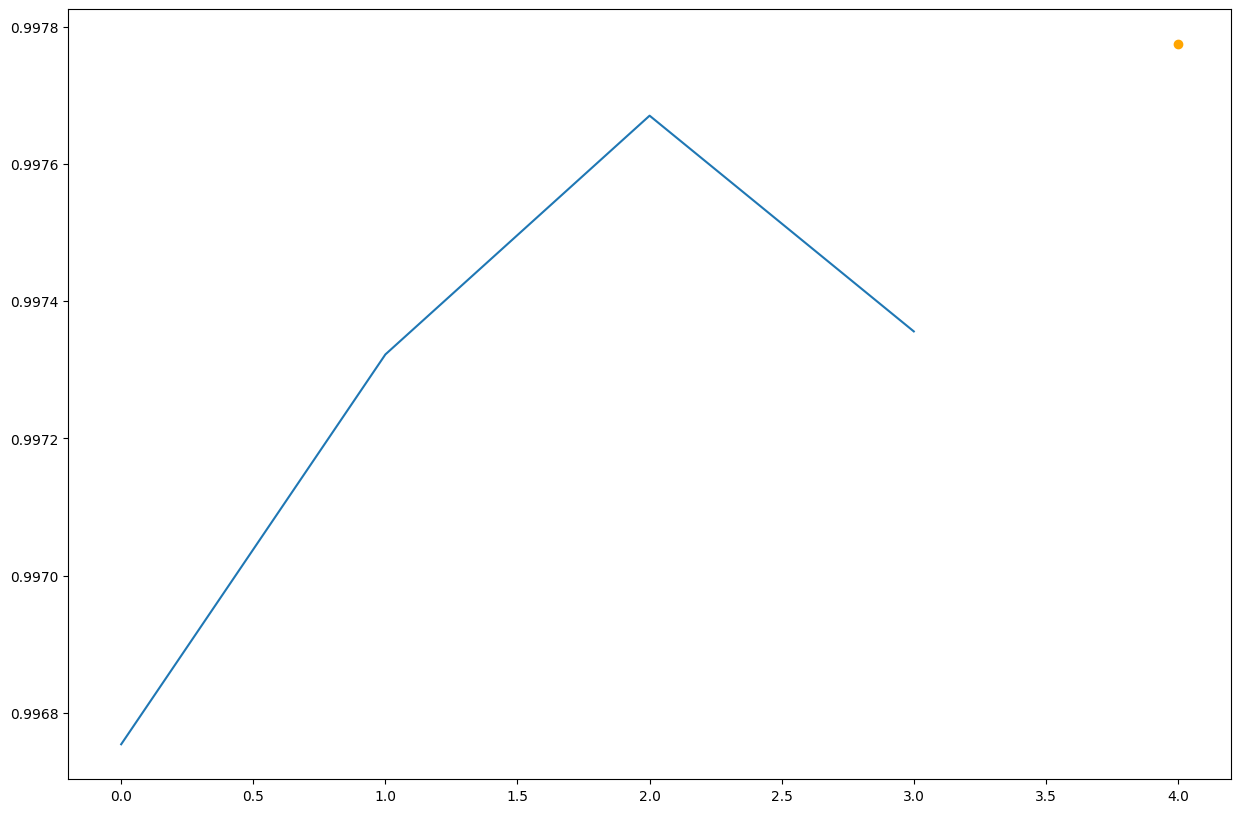

In [734]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(
    arr_transitions[:, 0],
    #axis = ax,
)

ax.scatter(
    [4], [vec_new[0]], 
    color = "orange"
    #axis = ax,
)